### Sistema Visão Computacional

- Processamento básico de imagens
- Detecção e segmentação
- Extração de características
- Transformações geométricas
- Aplicação de IA/ML para classificação de imagens

Utiliza o conjunto de dados CIFAR-10 para demonstrar as técnicas.

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from keras import layers, models
from keras.datasets import cifar10
from keras.utils import to_categorical
import os

### 1. Carregamento e Seleção de Imagens

In [18]:
# Função para carregar imagens personalizadas
def carregar_imagens_personalizadas(pasta_imagens="imagens_predict"):
    # Verifica se a pasta existe
    if not os.path.exists(pasta_imagens):
        print(f"AVISO: Pasta {pasta_imagens} não encontrada.")
        return None, None, None
    
    # Lista as imagens disponíveis
    nomes_arquivos = [f for f in os.listdir(pasta_imagens) 
                    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
    caminhos_imagens = [os.path.join(pasta_imagens, f) for f in nomes_arquivos]
    
    if len(caminhos_imagens) == 0:
        print(f"Nenhuma imagem encontrada na pasta {pasta_imagens}.")
        return None, None, None
    
    # Carrega as imagens
    imagens = []
    for caminho in caminhos_imagens:
        img = cv2.imread(caminho)
        if img is not None:
            # Redimensiona para 32x32 para manter consistência com CIFAR-10
            img = cv2.resize(img, (32, 32))
            imagens.append(img)
    
    # Cria um array numpy
    imagens_array = np.array(imagens)
    
    # Rótulos temporários (só para manter a estrutura, não serão usados para classificação nesta etapa)
    labels = np.zeros((len(imagens), 1))
    
    print(f"Carregadas {len(imagens)} imagens da pasta {pasta_imagens}")
    return imagens_array, labels, nomes_arquivos

# Carrega imagens do CIFAR-10
(x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = cifar10.load_data()

# Classes no CIFAR-10
class_names = ['avião', 'automóvel', 'pássaro', 'gato', 'veado', 'cachorro', 'sapo', 'cavalo', 'navio', 'caminhão']

Escolha o conjunto de imagens para processamento:
1. Imagens do CIFAR-10 (padrão)
2. Suas imagens personalizadas (da pasta imagens_predict)
Usando imagens do CIFAR-10


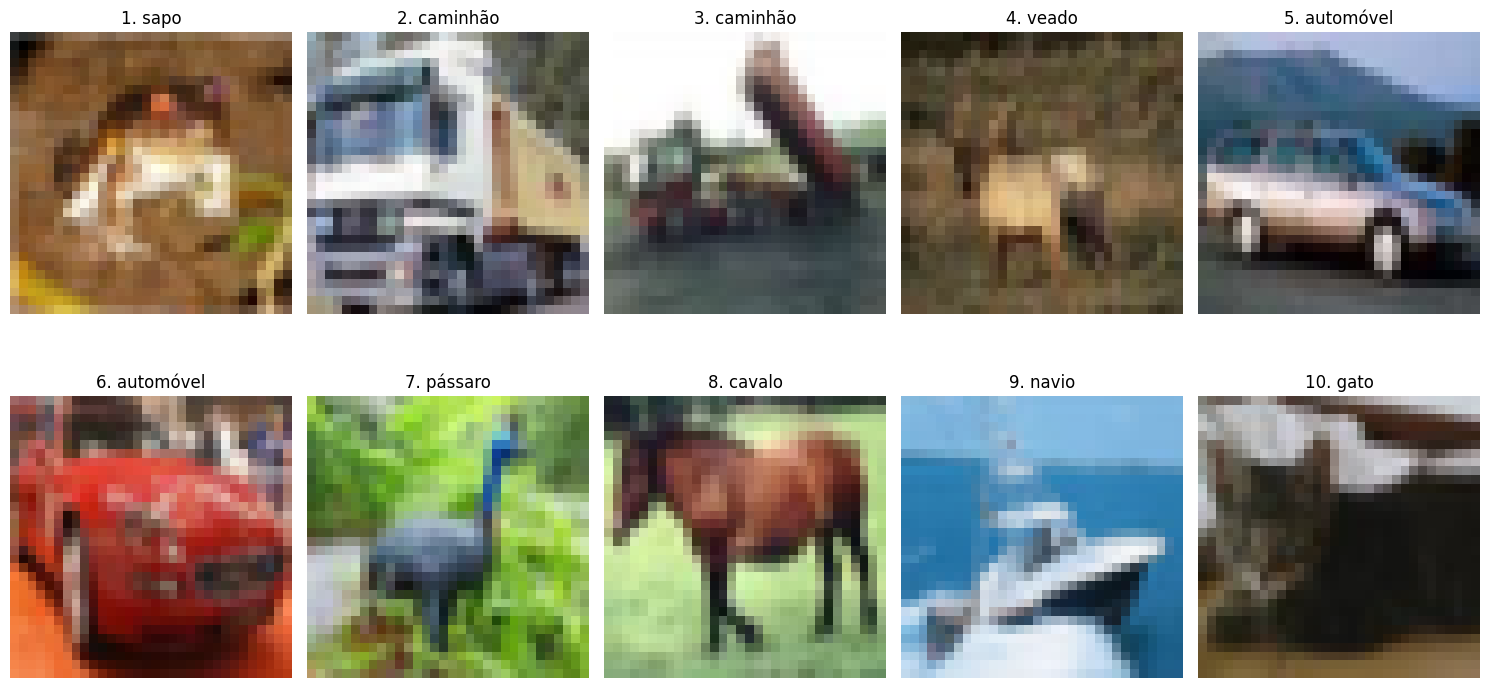

Processando imagem: sapo


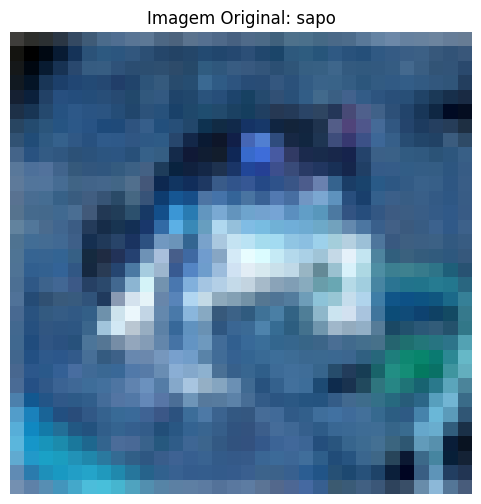

In [19]:
# Pergunta ao usuário qual conjunto de dados usar
print("Escolha o conjunto de imagens para processamento:")
print("1. Imagens do CIFAR-10 (padrão)")
print("2. Suas imagens personalizadas (da pasta imagens_predict)")

try:
    escolha = input("Digite sua escolha (1 ou 2): ")
    
    if escolha == "2":
        # Carregar imagens personalizadas
        x_imagens, y_imagens, nomes_arquivos = carregar_imagens_personalizadas()
        if x_imagens is not None:
            print("Usando imagens personalizadas")
            # Exibe as imagens disponíveis
            plt.figure(figsize=(15, 8))
            for i in range(len(x_imagens)):
                plt.subplot(2, 5, i+1) if i < 10 else None
                plt.imshow(cv2.cvtColor(x_imagens[i], cv2.COLOR_BGR2RGB))
                plt.title(f"{i+1}. {nomes_arquivos[i]}")
                plt.axis('off')
                if i >= 9:  # Limita a exibição a 10 imagens
                    break
            plt.tight_layout()
            plt.show()
            
            # Solicita ao usuário que escolha uma imagem
            escolha_imagem = input(f"\nEscolha uma imagem para processar (1-{min(10, len(x_imagens))}): ")
            try:
                idx_imagem = int(escolha_imagem) - 1
                if idx_imagem < 0 or idx_imagem >= len(x_imagens):
                    print(f"Número inválido. Usando a primeira imagem.")
                    idx_imagem = 0
            except ValueError:
                print("Entrada inválida. Usando a primeira imagem.")
                idx_imagem = 0
                
            # Seleciona apenas a imagem escolhida
            x_imagens_escolhida = x_imagens[idx_imagem:idx_imagem+1]
            y_imagens_escolhida = y_imagens[idx_imagem:idx_imagem+1]
            nome_imagem_escolhida = nomes_arquivos[idx_imagem]
            print(f"Processando imagem: {nome_imagem_escolhida}")
        else:
            print("Não foi possível carregar imagens personalizadas. Usando CIFAR-10 como alternativa.")
            escolha = "1"
    
    if escolha != "2" or x_imagens is None:
        # Usar CIFAR-10
        print("Usando imagens do CIFAR-10")
        # Exibe as primeiras 10 imagens para escolha
        plt.figure(figsize=(15, 8))
        for i in range(10):
            plt.subplot(2, 5, i+1)
            plt.imshow(x_train_cifar[i])
            plt.title(f"{i+1}. {class_names[y_train_cifar[i][0]]}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Solicita ao usuário que escolha uma imagem
        escolha_imagem = input("\nEscolha uma imagem para processar (1-10): ")
        try:
            idx_imagem = int(escolha_imagem) - 1
            if idx_imagem < 0 or idx_imagem >= 10:
                print("Número inválido. Usando a primeira imagem.")
                idx_imagem = 0
        except ValueError:
            print("Entrada inválida. Usando a primeira imagem.")
            idx_imagem = 0
            
        # Seleciona apenas a imagem escolhida
        x_imagens_escolhida = x_train_cifar[idx_imagem:idx_imagem+1]
        y_imagens_escolhida = y_train_cifar[idx_imagem:idx_imagem+1]
        nome_imagem_escolhida = class_names[y_train_cifar[idx_imagem][0]]
        print(f"Processando imagem: {nome_imagem_escolhida}")
        
except Exception as e:
    print(f"Erro: {e}")
    print("Usando a primeira imagem do CIFAR-10 como alternativa devido ao erro.")
    x_imagens_escolhida = x_train_cifar[0:1]
    y_imagens_escolhida = y_train_cifar[0:1]
    nome_imagem_escolhida = class_names[y_train_cifar[0][0]]

# Função para exibir imagens
def exibir_imagens(imagens, titulos=None, cmap=None):
    plt.figure(figsize=(15, 6))
    num_imagens = len(imagens)
    for i in range(num_imagens):
        plt.subplot(1, num_imagens, i+1)
        plt.imshow(imagens[i], cmap=cmap)
        if titulos is not None:
            plt.title(titulos[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Seleciona uma imagem de exemplo
imagem_original = x_imagens_escolhida[0]
imagem_rgb = cv2.cvtColor(imagem_original, cv2.COLOR_BGR2RGB)
imagem_gray = cv2.cvtColor(imagem_original, cv2.COLOR_BGR2GRAY)

# Exibe a imagem original
plt.figure(figsize=(6, 6))
plt.imshow(imagem_rgb)
if escolha == "1":
    plt.title(f'Imagem Original: {nome_imagem_escolhida}')
else:
    plt.title(f'Imagem Original: {nome_imagem_escolhida}')
plt.axis('off')
plt.show()

### 2. Processamento de Imagens

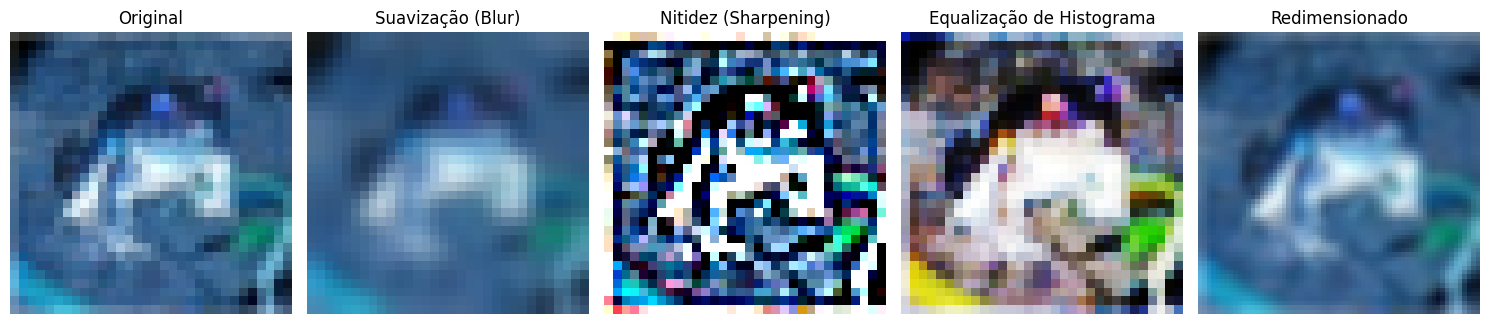

In [20]:
# Aplica diferentes técnicas de pré-processamento

# 1. Suavização (Blur)
blur = cv2.GaussianBlur(imagem_rgb, (5, 5), 0)

# 2. Nitidez (Sharpening)
kernel_sharpening = np.array([[-1,-1,-1], 
                              [-1, 9,-1],
                              [-1,-1,-1]])
sharpened = cv2.filter2D(imagem_rgb, -1, kernel_sharpening)

# 3. Equalização de histograma (colorida)
def equalize_hist_color(img):
    # Separar os canais
    b, g, r = cv2.split(img)
    
    # Equalizar cada canal
    b_eq = cv2.equalizeHist(b)
    g_eq = cv2.equalizeHist(g)
    r_eq = cv2.equalizeHist(r)
    
    # Combinar os canais
    return cv2.merge([b_eq, g_eq, r_eq])

# Aplicar a equalização colorida
eq_hist_color = equalize_hist_color(imagem_original)

# 4. Redimensionamento
resized = cv2.resize(imagem_rgb, (64, 64))

# Exibe os resultados
exibir_imagens(
    [imagem_rgb, blur, sharpened, eq_hist_color, resized],
    ['Original', 'Suavização (Blur)', 'Nitidez (Sharpening)', 'Equalização de Histograma', 'Redimensionado']
)

### 3. Detecção e Segmentação

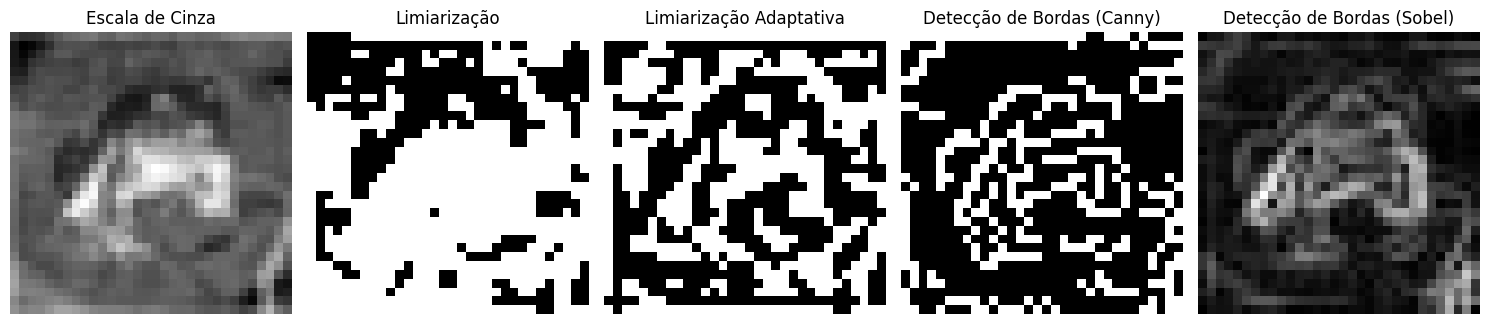

In [21]:
# Converte para escala de cinza (se ainda não estiver)
if len(imagem_gray.shape) > 2:
    imagem_gray = cv2.cvtColor(imagem_gray, cv2.COLOR_BGR2GRAY)

# 1. Segmentação por limiarização (thresholding)
ret, thresh = cv2.threshold(imagem_gray, 80, 255, cv2.THRESH_BINARY)

# 2. Limiarização adaptativa
thresh_adaptive = cv2.adaptiveThreshold(imagem_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                        cv2.THRESH_BINARY, 9, 2)

# 3. Detecção de bordas usando Canny
edges_canny = cv2.Canny(imagem_gray, 100, 200)

# 4. Detecção de bordas usando Sobel
sobelx = cv2.Sobel(imagem_gray, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(imagem_gray, cv2.CV_64F, 0, 1, ksize=3)
sobel_combined = cv2.magnitude(sobelx, sobely)
sobel_combined = cv2.normalize(sobel_combined, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

# Exibe os resultados
exibir_imagens(
    [imagem_gray, thresh, thresh_adaptive, edges_canny, sobel_combined],
    ['Escala de Cinza', 'Limiarização', 'Limiarização Adaptativa', 'Detecção de Bordas (Canny)', 'Detecção de Bordas (Sobel)'],
    cmap='gray'
)

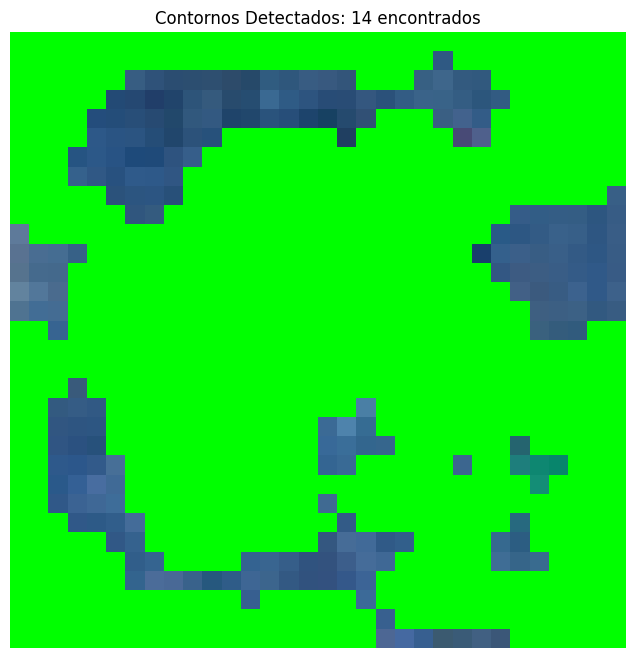

In [22]:
# Encontra contornos a partir da detecção de bordas
contours, hierarchy = cv2.findContours(edges_canny.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Desenha os contornos na imagem original
contour_img = imagem_rgb.copy()
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)

# Exibe a imagem com contornos
plt.figure(figsize=(8, 8))
plt.imshow(contour_img)
plt.title(f'Contornos Detectados: {len(contours)} encontrados')
plt.axis('off')
plt.show()

### 4. Extração de Características

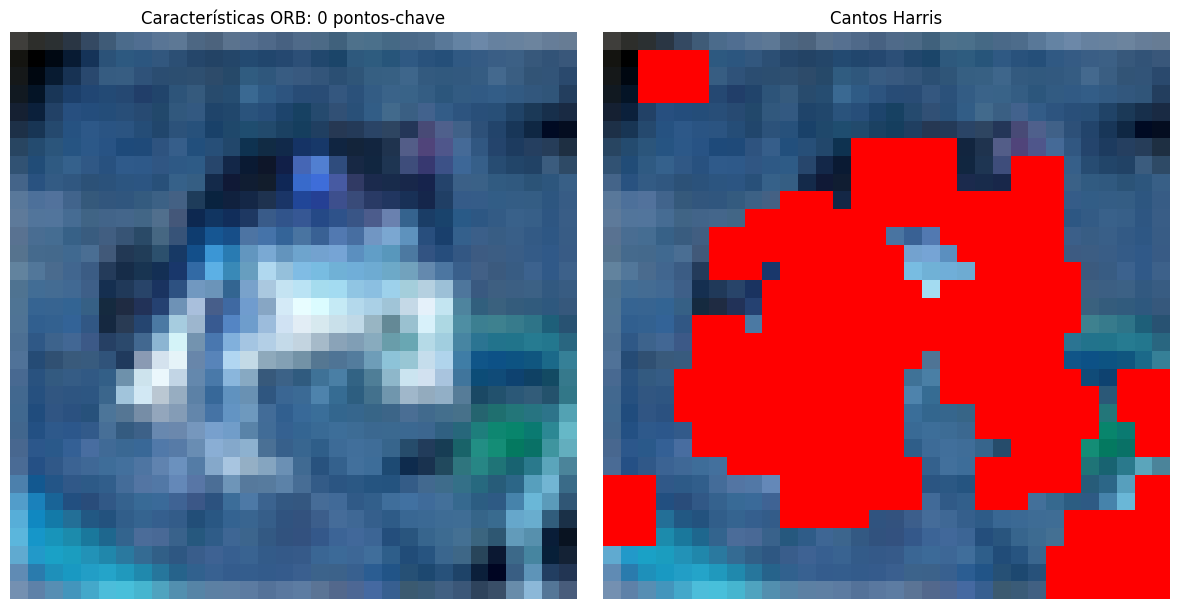

In [23]:
# Converte a imagem para formato adequado para detectores de características
img_for_features = imagem_gray.astype(np.uint8)

# 1. Detecta características ORB (Oriented FAST and Rotated BRIEF)
orb = cv2.ORB_create(nfeatures=100)
keypoints_orb, descriptors_orb = orb.detectAndCompute(img_for_features, None)

# 2. Detecta cantos Harris
harris_corners = cv2.cornerHarris(np.float32(img_for_features), 2, 3, 0.04)
harris_corners = cv2.dilate(harris_corners, None)

# Desenha os keypoints detectados pelo ORB
img_keypoints_orb = cv2.drawKeypoints(imagem_rgb, keypoints_orb, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Cria uma imagem para mostrar os cantos Harris
img_harris = imagem_rgb.copy()
threshold = 0.01 * harris_corners.max()
img_harris[harris_corners > threshold] = [255, 0, 0]

# Exibe os resultados
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_keypoints_orb)
plt.title(f'Características ORB: {len(keypoints_orb)} pontos-chave')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_harris)
plt.title('Cantos Harris')
plt.axis('off')

plt.tight_layout()
plt.show()

### Uso das Características para Classificação ou Comparação

Os descritores extraídos com ORB podem também ser usados para:

1. Comparação de imagens:
   - Calcula os descritores pra pares de imagens e tammbém usa os algoritmos como BFMatcher para encontrar as correspondências.
   - A quantidade de correspondências boas pode indicar similaridade entre as imagens.

2. Classificação de imagens:
   - Extrai descritores de um conjunto de imagens de treinamento.
   - Cria um histograma de palavras visuais.
   - Treina um classificador usando esses histogramas.
   - Classifica as novas imagens baseado nos seus histogramas de palavras visuais.

### 5. Transformações Geométricas e Homografia

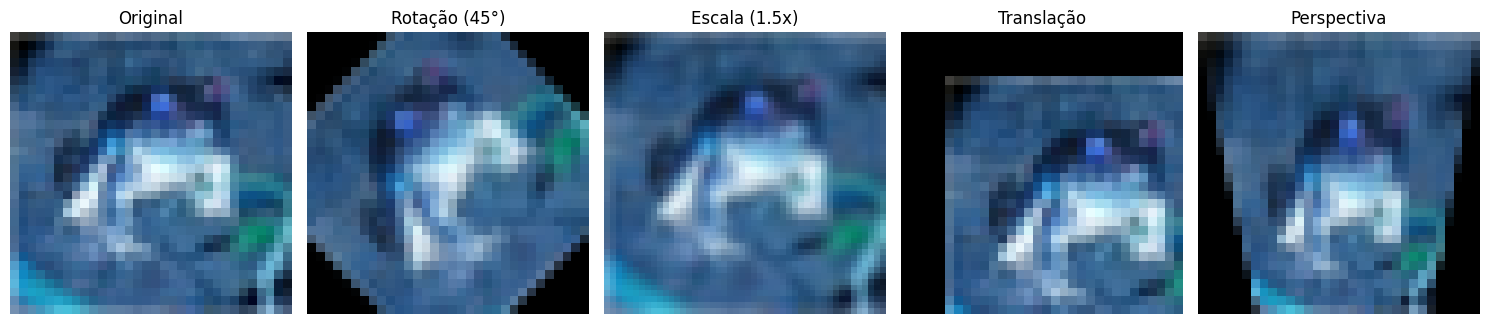

In [24]:
# Usa a imagem original para aplicar transformações
img_transform = imagem_rgb.copy()
height, width = img_transform.shape[:2]

# 1. Rotação
matriz_rotacao = cv2.getRotationMatrix2D((width/2, height/2), 45, 1)
img_rotacionada = cv2.warpAffine(img_transform, matriz_rotacao, (width, height))

# 2. Escala (redimensionamento)
img_escala = cv2.resize(img_transform, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_LINEAR)

# 3. Translação
matriz_translacao = np.float32([[1, 0, 5], [0, 1, 5]])
img_translacao = cv2.warpAffine(img_transform, matriz_translacao, (width, height))

# 4. Transformação de perspectiva
pts1 = np.float32([[0, 0], [width-1, 0], [0, height-1], [width-1, height-1]])
pts2 = np.float32([[0, 0], [width-1, 0], [width*0.2, height-1], [width*0.8, height-1]])
matriz_perspectiva = cv2.getPerspectiveTransform(pts1, pts2)
img_perspectiva = cv2.warpPerspective(img_transform, matriz_perspectiva, (width, height))

# Exibe resultados
exibir_imagens(
    [img_transform, img_rotacionada, img_escala, img_translacao, img_perspectiva],
    ['Original', 'Rotação (45°)', 'Escala (1.5x)', 'Translação', 'Perspectiva']
)

### 6. Aplicação de IA e ML

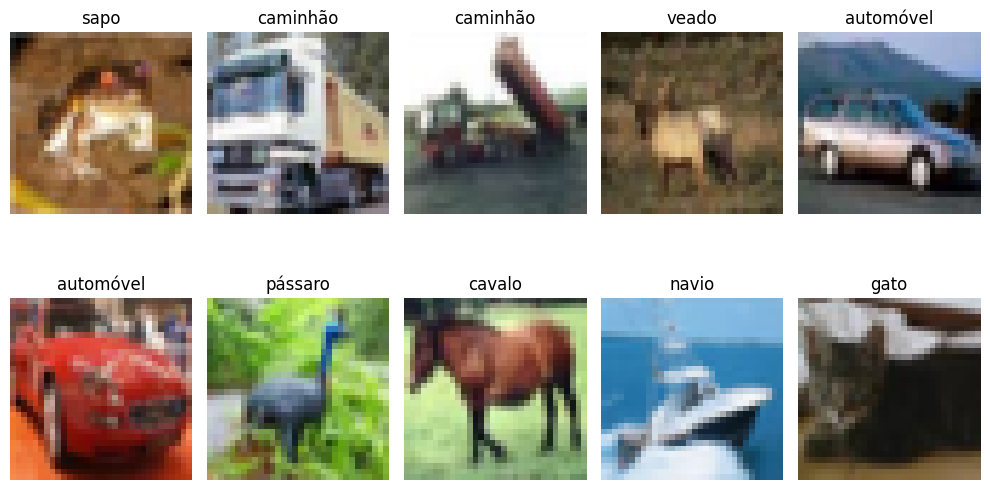

In [25]:
# Prepara os dados do CIFAR-10
(x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = cifar10.load_data()

# Normalização dos dados
x_train_cifar = x_train_cifar.astype('float32') / 255.0
x_test_cifar = x_test_cifar.astype('float32') / 255.0

# Conversão das etiquetas para one-hot encoding
y_train_one_hot = to_categorical(y_train_cifar, 10)
y_test_one_hot = to_categorical(y_test_cifar, 10)

# Exibe algumas imagens de exemplo
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train_cifar[i])
    plt.title(class_names[y_train_cifar[i][0]])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [26]:
# Constroe o modelo CNN
model = models.Sequential([
    # Primeira camada convolucional
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    # Segunda camada convolucional
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    # Terceira camada convolucional
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
    
    # Flatten e camadas densas
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

# Compilando o modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Resumo do modelo
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

In [27]:
# Define callbacks para melhorar o treinamento
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    min_lr=1e-6
)

# Usa o dataset completo, com uma divisão adequada para validação
# Reserva 20% dos dados para validação (10000 amostras)
validation_split = 0.2
validation_samples = int(x_train_cifar.shape[0] * validation_split)
train_samples = x_train_cifar.shape[0] - validation_samples

# Divide os dados em conjuntos de treinamento e validação
x_train_full = x_train_cifar[:train_samples]
y_train_full = y_train_one_hot[:train_samples]
x_val = x_train_cifar[train_samples:]
y_val = y_train_one_hot[train_samples:]

print(f"Usando {train_samples} amostras para treinamento e {validation_samples} para validação")

# Ajusta hiperparâmetros para o conjunto de dados completo
batch_size = 64

# Treina o modelo com o conjunto completo de dados
history = model.fit(
    x_train_full, y_train_full, 
    batch_size=batch_size, 
    epochs=25,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

# Adicionando informações sobre o tempo de treinamento
print(f"Treinamento concluído em {len(history.epoch)} epochs")

Usando 40000 amostras para treinamento e 10000 para validação
Epoch 1/25
625/625 [==============================] - 78s 122ms/step - loss: 1.6415 - accuracy: 0.4372 - val_loss: 1.4095 - val_accuracy: 0.4792 - lr: 0.0010
Epoch 2/25
625/625 [==============================] - 76s 121ms/step - loss: 1.1148 - accuracy: 0.6043 - val_loss: 0.9755 - val_accuracy: 0.6616 - lr: 0.0010
Epoch 3/25
625/625 [==============================] - 74s 118ms/step - loss: 0.9386 - accuracy: 0.6694 - val_loss: 0.8570 - val_accuracy: 0.7014 - lr: 0.0010
Epoch 4/25
625/625 [==============================] - 74s 118ms/step - loss: 0.8367 - accuracy: 0.7096 - val_loss: 0.7471 - val_accuracy: 0.7382 - lr: 0.0010
Epoch 5/25
625/625 [==============================] - 92s 148ms/step - loss: 0.7658 - accuracy: 0.7336 - val_loss: 0.9581 - val_accuracy: 0.6780 - lr: 0.0010
Epoch 6/25
625/625 [==============================] - 76s 122ms/step - loss: 0.7098 - accuracy: 0.7536 - val_loss: 0.7258 - val_accuracy: 0.7470 - l

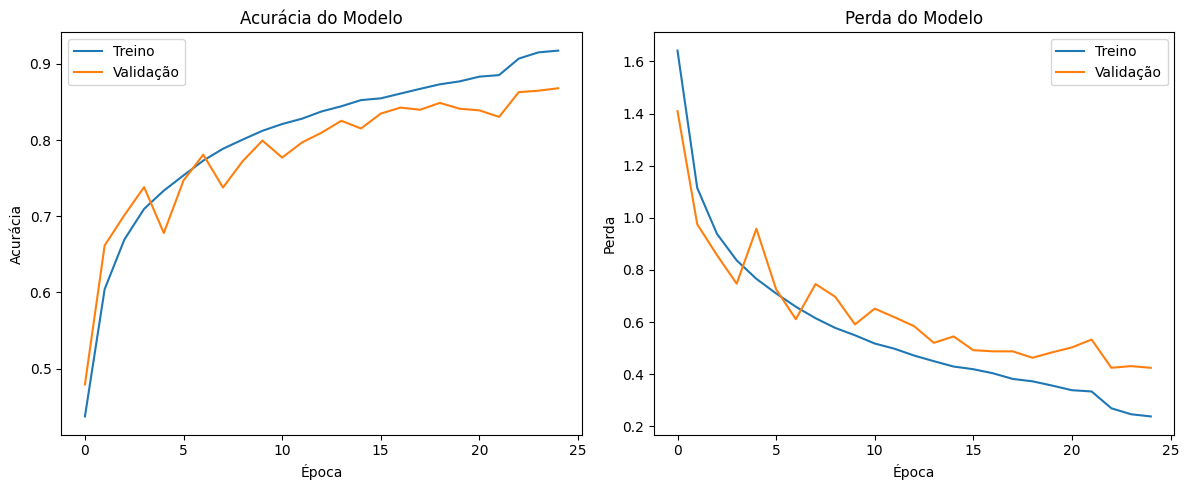

In [28]:
# Visualizando a história do treinamento
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda do Modelo')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()

32/32 [==============================] - 0s 12ms/step - loss: 0.4044 - accuracy: 0.8750
Acurácia no conjunto de testes: 0.8750
32/32 [==============================] - 1s 16ms/step


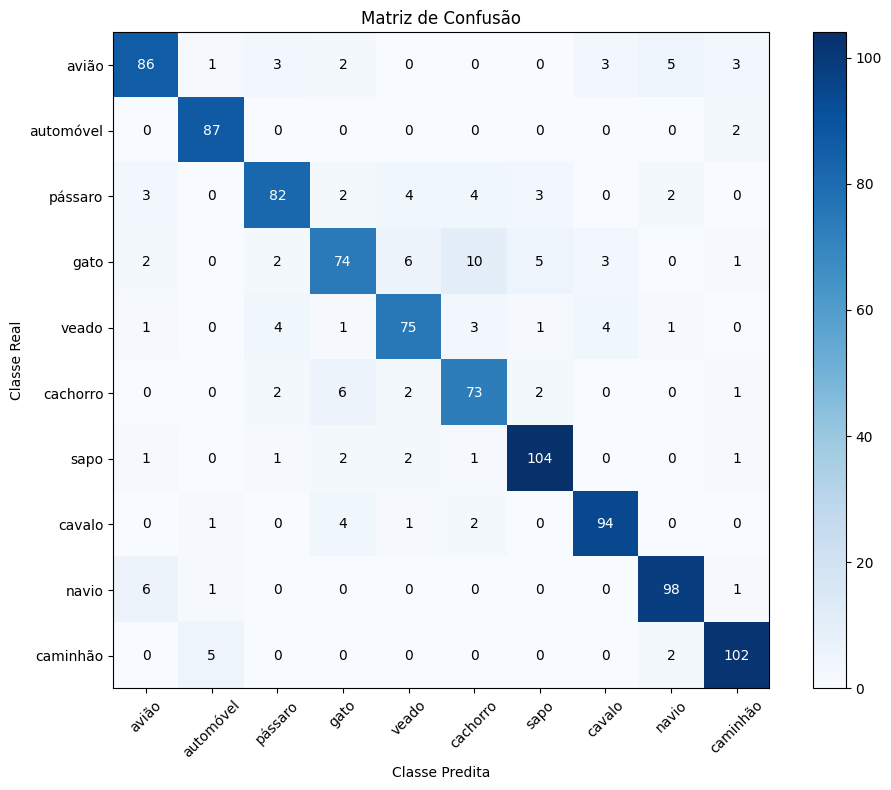

In [29]:
# Avalia o modelo no conjunto de testes
# Usa um subconjunto para economizar tempo
x_test_subset = x_test_cifar[:1000]
y_test_subset = y_test_one_hot[:1000]
y_test_labels = y_test_cifar[:1000]

test_loss, test_acc = model.evaluate(x_test_subset, y_test_subset)
print(f'Acurácia no conjunto de testes: {test_acc:.4f}')

# Faz previsões
predicoes = model.predict(x_test_subset)
predicoes_classes = np.argmax(predicoes, axis=1)

# Matriz de confusão
conf_matrix = confusion_matrix(y_test_labels, predicoes_classes)

# Plota a matriz de confusão
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

fmt = 'd'
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], fmt),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('Classe Real')
plt.xlabel('Classe Predita')
plt.tight_layout()
plt.show()

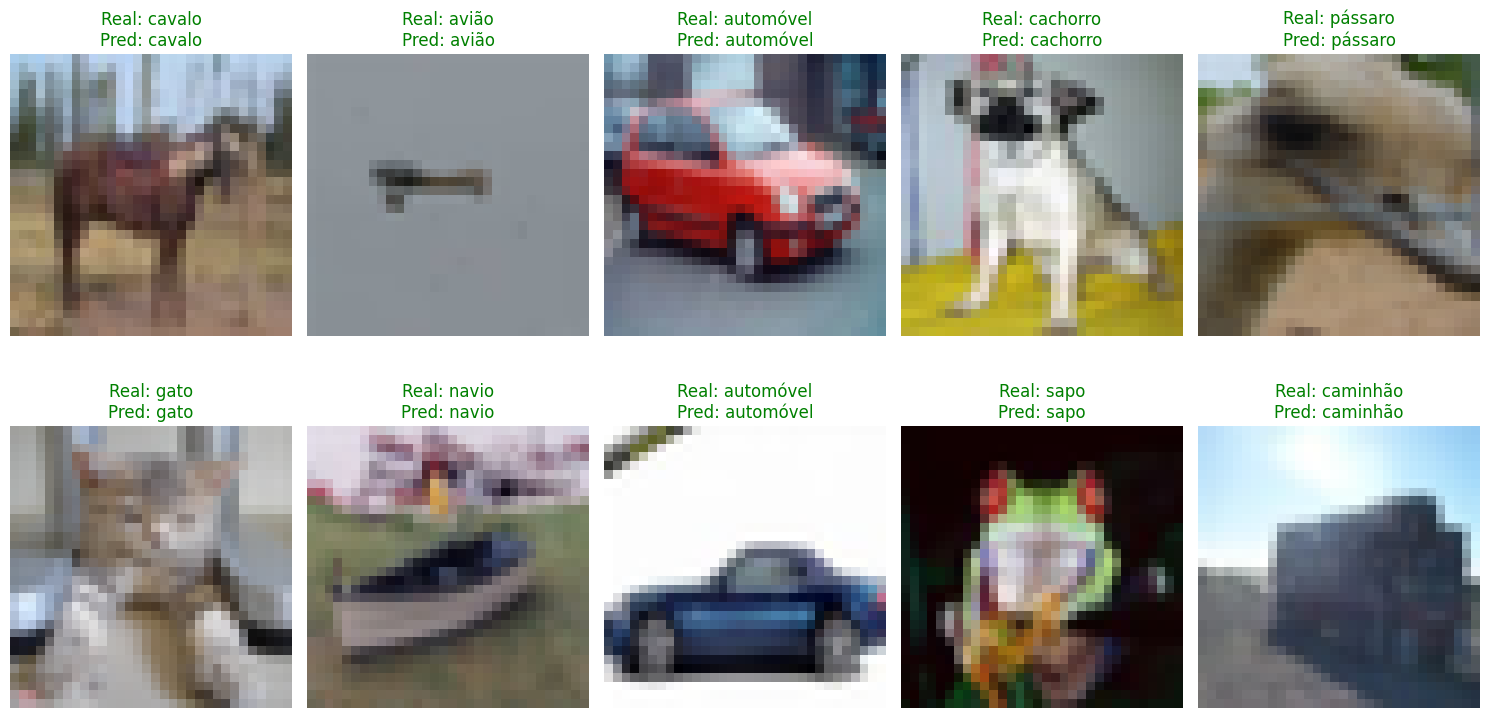

In [30]:
# Visualiza algumas previsões
num_exemplos = 10
indices = np.random.choice(len(x_test_subset), num_exemplos, replace=False)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_test_subset[idx])
    pred_class = predicoes_classes[idx]
    true_class = y_test_labels[idx][0]
    
    titulo = f'Real: {class_names[true_class]}\nPred: {class_names[pred_class]}'
    plt.title(titulo, color='green' if pred_class == true_class else 'red')
    plt.axis('off')
    
plt.tight_layout()
plt.show()

### 7. Predição em Imagens Próprias


In [31]:
# Função para processar e prever a imagem
def prever_imagem_propria(caminho_imagem, modelo, class_names):
    try:
        # Carrega a imagem
        img = cv2.imread(caminho_imagem)
        if img is None:
            return None, "Erro ao carregar a imagem. Verifique o caminho."
        
        # Converte de BGR para RGB para visualização
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Redimensiona para 32x32 (tamanho esperado pelo modelo CIFAR-10)
        img_resized = cv2.resize(img, (32, 32))
        
        # Normaliza os valores dos pixels
        img_normalizada = img_resized.astype('float32') / 255.0
        
        # Expande as dimensões para o formato esperado pelo modelo
        img_batch = np.expand_dims(img_normalizada, axis=0)
        
        # Faz a predição
        predicao = modelo.predict(img_batch)
        classe_predita = np.argmax(predicao[0])
        confianca = predicao[0][classe_predita] * 100  # Confiança em porcentagem
        
        return {
            'img_original': img_rgb,
            'img_processada': img_normalizada,
            'classe_predita': classe_predita,
            'nome_classe': class_names[classe_predita],
            'confianca': confianca,
            'todas_prob': predicao[0]
        }, None
    except Exception as e:
        return None, f"Erro ao processar a imagem: {str(e)}"

def exibir_resultados_predicao(resultado, class_names):
    if resultado is None:
        print("Não há resultados para exibir.")
        return
    
    # Exibe a imagem original e o resultado da predição
    plt.figure(figsize=(12, 6))
    
    # Imagem original
    plt.subplot(1, 2, 1)
    plt.imshow(resultado['img_original'])
    plt.title("Imagem Original")
    plt.axis('off')
    
    # Imagem processada
    plt.subplot(1, 2, 2)
    plt.imshow(resultado['img_processada'])
    plt.title(f"Processada (32x32)")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Resultado da predição
    print(f"Classe predita: {resultado['nome_classe']}")
    print(f"Confiança: {resultado['confianca']:.2f}%")
    
    # Gráfico de barras mostrando a confiança para todas as classes
    plt.figure(figsize=(10, 6))
    plt.bar(class_names, resultado['todas_prob'] * 100)
    plt.xlabel("Classes")
    plt.ylabel("Confiança (%)")
    plt.title("Distribuição de Probabilidades por Classe")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Imagens encontradas (10):
1. automovel.jpg
2. aviao.png
3. cachorro.jpg
4. caminhao.jpg
5. cavalo.jpg
6. gato.jpg
7. navio.jpg
8. passaro.jpg
9. sapo.jpg
10. veado.jpeg

Processando: imagens_predict\automovel.jpg
1/1 [==============================] - 0s 200ms/step


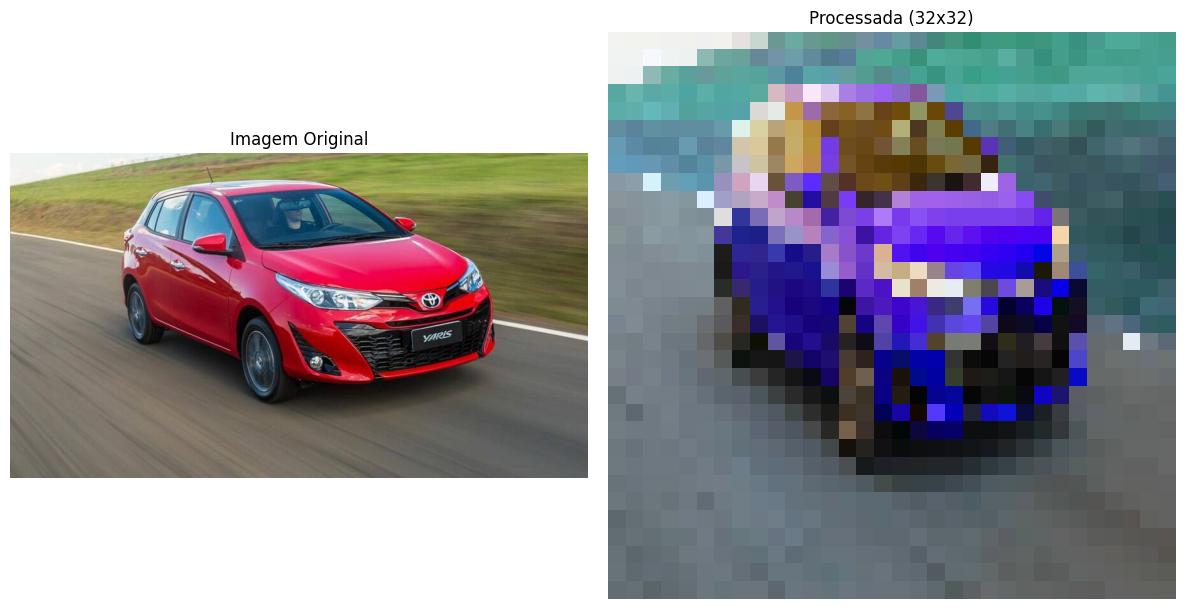

Classe predita: automóvel
Confiança: 93.20%


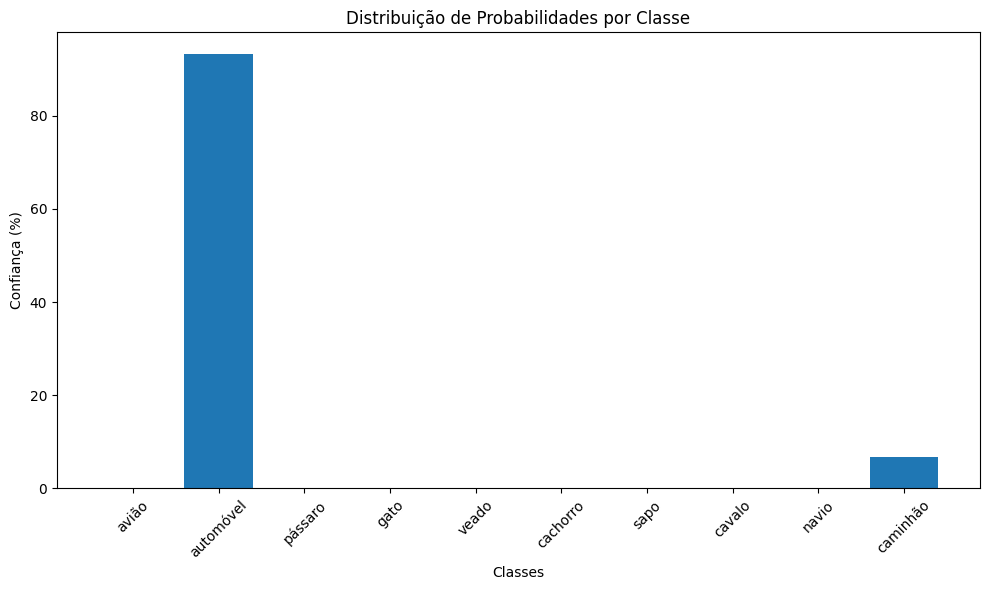

In [32]:
# Pasta de imagens
pasta_imagens = "imagens_predict"

# Verifica se a pasta existe
if not os.path.exists(pasta_imagens):
    print(f"AVISO: Pasta {pasta_imagens} não encontrada. Criando pasta...")
    os.makedirs(pasta_imagens)
    print(f"Coloque suas imagens na pasta {pasta_imagens} e execute esta célula novamente.")
else:
    # Lista as imagens disponíveis
    imagens = [f for f in os.listdir(pasta_imagens) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
    
    if len(imagens) == 0:
        print(f"Nenhuma imagem encontrada na pasta {pasta_imagens}.")
        print("Adicione algumas imagens e execute esta célula novamente.")
    else:
        print(f"Imagens encontradas ({len(imagens)}):")
        for i, img in enumerate(imagens):
            print(f"{i+1}. {img}")
        
        # Solicita ao usuário que escolha uma imagem
        escolha = input("\nDigite o número da imagem que deseja processar: ")
        try:
            idx = int(escolha) - 1
            if idx < 0 or idx >= len(imagens):
                print(f"Número inválido. Escolha entre 1 e {len(imagens)}.")
            else:
                # Processa a imagem selecionada
                caminho_imagem = os.path.join(pasta_imagens, imagens[idx])
                print(f"\nProcessando: {caminho_imagem}")
                
                # Faz a predição
                resultado, erro = prever_imagem_propria(caminho_imagem, model, class_names)
                
                if erro:
                    print(f"Erro: {erro}")
                else:
                    exibir_resultados_predicao(resultado, class_names)
        except ValueError:
            print("Por favor, digite um número válido.")

### Relatório e Explicação do Modelo

### Arquitetura do Modelo
Foi construido uma CNN com as características seguintes:
- 3 blocos de camadas convolucionais, com cada um possuindo duas camadas Conv2D seguidas de normalização em lote e max pooling
- Dropout em cada um dos bloco para reduzir overfitting
- Camadas fully-connected no final para a classificação
- Função de ativação softmax na camada de saída para classificação de multi-classe

### Treinamento
- Conjunto de dados: CIFAR-10
- Pré-processamento: normalização das imagens (dividindo por 255)
- Otimizador: Adam com taxa de aprendizado adaptativa
- Função de perda: Entropia cruzada categórica
- Callbacks: Early stopping e redução da taxa de aprendizado quando é necessário

### Avaliação
- Métricas: Acurácia, matriz de confusão
- O modelo aprenderu a diferenciar as diferentes classes com uma acurácia razoável
- Erros comuns ainda ocorrem entre algumas classes parecidas, principalmente gato e cachorro

### Predição em Imagens Próprias
- Funcionalidade para carregar e fazer predições em imagens personalizadas desde esteja de acordo com as classes de imagens presentes no CIFAR-10
- Pré-processamento automático das imagens (redimensionamento para 32x32 e normalização)
- Visualização dos resultados com:
    - Imagem original e imagem processada
    - Classe predita e nível de confiança
    - Gráfico de distribuição de probabilidades entre todas as classes

### Aplicações e Limitações
- Aplicações: Classificação de objetos em imagens e reconhecimento de padrões
- Limitações: Desempenho limitado em objetos que não são presentes no conjunto de treinamento ou em algumas condições diferentes das imagens de treinamento
- Possíveis melhorias: Aumento de dados (data augmentation), arquiteturas mais profundas, transferência de aprendizado de modelos pré-treinados
- O modelo foi treinado apenas nas 10 classes do CIFAR-10, então a precisão será melhor para imagens similares desse conjunto

### Conclusão

Foi implementado um sistema que inclui:

1. **Processamento de Imagens**: Aplicação de filtros, equalização de histograma e redimensionamento.
2. **Detecção e Segmentação**: Utilização de limiarização e detecção de bordas para identificar objetos.
3. **Extração de Características**: Identificação dos pontos-chave usando ORB e cantos Harris.
4. **Transformações Geométricas**: Aplicação de rotação, escala, translação e transformação de perspectiva.
5. **Aplicação de IA/ML**: Construção e treinamento de uma CNN para classificar imagens presentes no CIFAR-10.
6. **Inferência em Imagens Novas**: Capacidade de utilizar o modelo treinado para classificar imagens fornecidas pelo usuário.